# FSM: First Simple Model 

# Overview

# Business Problem

# Data Understanding

Due to the size of the dataset, I can not directly push it to my online repository. The **dataset can be accessed here**:

- [2022 BRFSS Survey Data and Documentation](https://www.cdc.gov/brfss/annual_data/annual_2022.html)

The **codebook** can be accessed here:

- [LLCP 2022: Codebook Report](/Users/emmascotson/Documents/capstone_flatiron/data/Codebook_Report.pdf)

# Data Preparation

# Modeling

# Evaluation

In [1]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer

from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.datasets import make_classification

In [2]:
import os
print(os.getcwd())
# List files in the current directory
print(os.listdir('.'))

/Users/emmascotson/Documents/capstone_flatiron/notebooks
['Capstone.ipynb', '.ipynb_checkpoints']


# Loading the Data

In [3]:
# Specify the full path to the XPT file
file_path = '/Users/emmascotson/Documents/capstone_flatiron/data/diabetes.xpt'

# Attempt to read the XPT file
try:
    data = pd.read_sas(file_path, format='xport')
    print(data.head())
except FileNotFoundError as e:
    print(f"Error: {e}")
except Exception as e:
    print(f"An error occurred: {e}")

   _STATE  FMONTH        IDATE IMONTH   IDAY    IYEAR  DISPCODE  \
0     1.0     1.0  b'02032022'  b'02'  b'03'  b'2022'    1100.0   
1     1.0     1.0  b'02042022'  b'02'  b'04'  b'2022'    1100.0   
2     1.0     1.0  b'02022022'  b'02'  b'02'  b'2022'    1100.0   
3     1.0     1.0  b'02032022'  b'02'  b'03'  b'2022'    1100.0   
4     1.0     1.0  b'02022022'  b'02'  b'02'  b'2022'    1100.0   

           SEQNO          _PSU  CTELENM1  ...  _SMOKGRP  _LCSREC  DRNKANY6  \
0  b'2022000001'  2.022000e+09       1.0  ...       4.0      NaN       2.0   
1  b'2022000002'  2.022000e+09       1.0  ...       4.0      NaN       2.0   
2  b'2022000003'  2.022000e+09       1.0  ...       4.0      NaN       2.0   
3  b'2022000004'  2.022000e+09       1.0  ...       3.0      2.0       2.0   
4  b'2022000005'  2.022000e+09       1.0  ...       4.0      NaN       1.0   

       DROCDY4_  _RFBING6      _DRNKWK2  _RFDRHV8  _FLSHOT7  _PNEUMO3  \
0  5.397605e-79       1.0  5.397605e-79       1.0      

In [4]:
data.head()

,_STATE,FMONTH,IDATE,IMONTH,IDAY,IYEAR,DISPCODE,SEQNO,_PSU,CTELENM1,...,_SMOKGRP,_LCSREC,DRNKANY6,DROCDY4_,_RFBING6,_DRNKWK2,_RFDRHV8,_FLSHOT7,_PNEUMO3,_AIDTST4
0,1.0,1.0,b'02032022',b'02',b'03',b'2022',1100.0,b'2022000001',2.022000e+09,1.0,...,4.0,NaN,2.0,5.397605e-79,1.0,5.397605e-79,1.0,1.0,2.0,2.0
1,1.0,1.0,b'02042022',b'02',b'04',b'2022',1100.0,b'2022000002',2.022000e+09,1.0,...,4.0,NaN,2.0,5.397605e-79,1.0,5.397605e-79,1.0,2.0,2.0,2.0
2,1.0,1.0,b'02022022',b'02',b'02',b'2022',1100.0,b'2022000003',2.022000e+09,1.0,...,4.0,NaN,2.0,5.397605e-79,1.0,5.397605e-79,1.0,NaN,NaN,2.0
3,1.0,1.0,b'02032022',b'02',b'03',b'2022',1100.0,b'2022000004',2.022000e+09,1.0,...,3.0,2.0,2.0,5.397605e-79,1.0,5.397605e-79,1.0,9.0,9.0,2.0
4,1.0,1.0,b'02022022',b'02',b'02',b'2022',1100.0,b'2022000005',2.022000e+09,1.0,...,4.0,NaN,1.0,1.000000e+01,1.0,1.400000e+02,1.0,NaN,NaN,2.0


In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 445132 entries, 0 to 445131
Columns: 328 entries, _STATE to _AIDTST4
dtypes: float64(323), object(5)
memory usage: 1.1+ GB


# Preprocessing

## Filtering for Genetic/Involuntary 

I'll keep a few of the behavioral categories that have clear severe impacts on physical health, such as smoking and drinking habits -- so I can better compare whether someone's symptoms might be related to disease-prone genetics inherited from their parents or the result of smoking a pack of cigarettes a day for the past 40 years. 

Since I'll be adding many other behavioral columns in later, for our larger model, I'll be sparing for this preliminary model.

In [6]:
columns_to_keep = ['CADULT1', 'CELLSEX1', 'CSTATE1', 'SEXVAR', 'GENHLTH', 'PHYSHLTH', 'PRIMINSR', 
                   'PERSDOC3', 'MEDCOST1', 'RMVTETH4', 'CVDINFR4', 'CVDCRHD4', 'CVDSTRK3', 'ASTHMA3',
                   'ASTHNOW', 'CHCSCNC1', 'CHCOCNC1', 'PREGNANT', 'WEIGHT2', 'HEIGHT3', 'DEAF',
                   'BLIND', 'DECIDE', 'DIFFWALK', 'CERVSCRN', 'SMOKE100', 'SMOKDAY2', 'LCSCTSC1',
                   '_STATE', 'LCSSCNCR', 'PDIABTS1', 'PREDIAB2', 'DIABETE4', 'DIABTYPE', 'INSULIN1',
                   'CHKHEMO3', 'EYEEXAM1', 'DIABEYE1', 'FEETSORE', 'TOLDCFS', 'HAVECFS', 'COPDCOGH',
                   'COPDFLEM', 'COPDBTST', 'CNCRDIFF', 'CNCRAGE', 'CNCRTYP2', 'CSRVDOC1', 'CSRVSUM',
                   'CSRVRTRN', 'PSATEST1', 'CIMEMLOS', 'CDDISCUS', 'CAREGIV1', 'CRGVREL4', 'CRGVPRB3',
                   'CRGVALZD', 'LSATISFY', 'ASBIRDUC', 'BIRTHSEX', 'TRNSGNDR', 'RRCLASS3', 'RRHCARE4',
                   'RRPHYSM2', '_METSTAT', '_URBSTAT', 'MSCODE', '_IMPRACE', '_CHISPNC', '_RFHLTH',
                   '_PHYS14D', '_HLTHPLN', '_HCVU652', '_MICHD', '_LTASTH1', '_CASTHM1', '_ASTHMS1',
                   '_DRDXAR2', '_MRACE2', '_HISPANC', '_RACE1', '_RACEG22', '_RACEGR4', '_SEX', '_AGEG5YR',
                   '_AGE65YR', '_AGE80', '_AGE_G', 'HTIN4', 'WTKG3', '_BMI5', '_BMI5CAT', '_RFBMI5', 
                   '_INCOMG1', '_SMOKER3', '_YRSSMOK', '_SMOKGRP', '_LCSREC', '_RFBING6', '_RFDRHV8']

In [7]:
# Creating new filtered dataframe for First Simple Model

fsm = data[columns_to_keep]

In [8]:
fsm.head()

,CADULT1,CELLSEX1,CSTATE1,SEXVAR,GENHLTH,PHYSHLTH,PRIMINSR,PERSDOC3,MEDCOST1,RMVTETH4,...,_BMI5,_BMI5CAT,_RFBMI5,_INCOMG1,_SMOKER3,_YRSSMOK,_SMOKGRP,_LCSREC,_RFBING6,_RFDRHV8
0,NaN,NaN,NaN,2.0,2.0,88.0,99.0,1.0,2.0,NaN,...,NaN,NaN,9.0,9.0,4.0,NaN,4.0,NaN,1.0,1.0
1,NaN,NaN,NaN,2.0,1.0,88.0,3.0,2.0,2.0,NaN,...,2657.0,3.0,2.0,3.0,4.0,NaN,4.0,NaN,1.0,1.0
2,NaN,NaN,NaN,2.0,2.0,2.0,1.0,1.0,2.0,NaN,...,2561.0,3.0,2.0,6.0,4.0,NaN,4.0,NaN,1.0,1.0
3,NaN,NaN,NaN,2.0,1.0,88.0,99.0,1.0,2.0,NaN,...,2330.0,2.0,1.0,9.0,2.0,56.0,3.0,2.0,1.0,1.0
4,NaN,NaN,NaN,2.0,4.0,2.0,7.0,2.0,2.0,NaN,...,2177.0,2.0,1.0,3.0,4.0,NaN,4.0,NaN,1.0,1.0


In [9]:
fsm.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 445132 entries, 0 to 445131
Data columns (total 100 columns):
 #   Column    Non-Null Count   Dtype  
---  ------    --------------   -----  
 0   CADULT1   349080 non-null  float64
 1   CELLSEX1  349079 non-null  float64
 2   CSTATE1   349072 non-null  float64
 3   SEXVAR    445132 non-null  float64
 4   GENHLTH   445129 non-null  float64
 5   PHYSHLTH  445127 non-null  float64
 6   PRIMINSR  445128 non-null  float64
 7   PERSDOC3  445130 non-null  float64
 8   MEDCOST1  445128 non-null  float64
 9   RMVTETH4  443769 non-null  float64
 10  CVDINFR4  445128 non-null  float64
 11  CVDCRHD4  445130 non-null  float64
 12  CVDSTRK3  445130 non-null  float64
 13  ASTHMA3   445130 non-null  float64
 14  ASTHNOW   66694 non-null   float64
 15  CHCSCNC1  445130 non-null  float64
 16  CHCOCNC1  445129 non-null  float64
 17  PREGNANT  79018 non-null   float64
 18  WEIGHT2   429231 non-null  float64
 19  HEIGHT3   428077 non-null  float64
 20  DEA

## Nulls

Huh! It seems like there are some columns with completely missing values. Let's re-print the columns in ascending order of non-null values to reference back to the Codebook and examine whether our Null values are accurate. 

In [10]:
# Get non-null counts for each column
non_null_counts = fsm.notnull().sum()

# Sort columns by non-null counts in ascending order
sorted_columns = non_null_counts.sort_values().index

# Reorder DataFrame columns based on sorted order
fsm_sorted = fsm[sorted_columns]

# Print info of the sorted DataFrame
print(fsm_sorted.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 445132 entries, 0 to 445131
Data columns (total 100 columns):
 #   Column    Non-Null Count   Dtype  
---  ------    --------------   -----  
 0   HAVECFS   0 non-null       float64
 1   TOLDCFS   0 non-null       float64
 2   PSATEST1  7180 non-null    float64
 3   COPDBTST  7232 non-null    float64
 4   COPDFLEM  7262 non-null    float64
 5   COPDCOGH  7269 non-null    float64
 6   CDDISCUS  7400 non-null    float64
 7   CSRVRTRN  9771 non-null    float64
 8   CSRVSUM   9783 non-null    float64
 9   CSRVDOC1  9807 non-null    float64
 10  FEETSORE  12600 non-null   float64
 11  DIABEYE1  12600 non-null   float64
 12  EYEEXAM1  12600 non-null   float64
 13  CHKHEMO3  12600 non-null   float64
 14  INSULIN1  12600 non-null   float64
 15  DIABTYPE  12600 non-null   float64
 16  CRGVALZD  17300 non-null   float64
 17  CRGVPRB3  19472 non-null   float64
 18  CRGVREL4  19634 non-null   float64
 19  CNCRTYP2  22544 non-null   float64
 20  CNC

##### HAVECFS and TOLDCFS

The codebook confirms that the data is completely missing for all rows in these columns, which indicate a person's status with regards to having or being told they have **Chronic Fatigue Syndrome (CFS)** or **Myalgic Encephalomyelitis**. 

##### PSATEST1

Survey Question: *Have you ever had a P.S.A. test?*

*PSA test*: measures the amount of PSA in a man's blood to help screen for and monitor prostate cancer.

According to Cleveland Clinic PSA tests are very common. Which leaves us to wonder why so many of these values are Nulls -- certainly a far greater number than the amount of men that were surveyed in the dataset. 


##### COPDCOGH AND COPDFLEM

Survey Question: *During the past three months, did you have a cough and/or cough up phlegm or mucus on most days? 

These columns might be more of the **hindsight bias** symptoms I was referring to early, rather than prior warning signs. It's not a big deal if we have a lot of Nulls for these, we have other genetic and physical factors that will be far more important to our model. 

##### CDDISCUS

Survey Question: Have you are anyone else discussed your confusion or memory loss with a health care professional? 

Again, not one of our most important features, so no need to stress that there are a lot of Nulls. 

An interesting takeaway from the Codebook Report with regards to this feature: the **non**-missing values seemed to be pretty balanced between our two main class...3,432 'Yes' and 3,862 'No'. 

##### CSVRTRN, CSRVSUM

Survey Question CSVRTRN: Have you ever received instructions from a doctor, nurse, or other health professional about where you should return or who you should see for routine cancer check-
ups after completing treatment for cancer?

Survey Question CSRVSUM: Did any doctor, nurse, or other health professional ever give you a written summary of all the cancer treatments that you received?

These are sort of behavioral questions, as they bleed into the question of whether or not people choose to incorporate doctor's visits into their lifestyle routines. I thought they might be helpful in isolating whether people had **reasons** to go to the doctor (due to underlying genetic conditions), but there are other features we have that are more suitable for this anyway. 

##### CSRVDOC1 

Survey Question: What type of doctor provides the majority of your health care? Is it a….

This could still be useful, even if we have Nulls, to identify any specialized possibly genetic reasons a person requires specific medical care from a particular kind of doctor. But again, not entirely important compared to other features. So it's okay that we have mostly Nulls.

### Moving On

The rest of our columns have over 10,000 non-null values. To save time, I'll keep moving for now and examine these as I go if need be.

## Cleaning: Lowercase Column Names

Let's **lowercase all the column names**, to increase readability. 

#### Other Cleaning

There's such a large number of columnns, even in this smaller FSM -- I want to optomize time by moving on to explore the data and continuing to "clean as I go" if I run into any other issues. Rather than assessing any need to clean answer values for each column right now as well. 

Furthermore, from what I've seen in the Codebook, this dataset is extremely well-organized compared to some past datasets I've worked with. I therefore feel confident in assuming that most of the answer-values in the rows themselves are pretty clean, and I can optomize time by moving forward and dealing with any other issues as they arise. 

In [11]:
# lowercasing column names
fsm.columns = fsm.columns.str.lower()

# Codebook Key Dictionary: 'codebook_key'

To minimize the amount of time I have to refer back to the Codebook and/or scroll up and down through this notebook to reference old markdowns...I'm going to make a **dictionary called 'codebook_key'** which contains column names and the meanings of their answer values as key-value pairs. 

I will do this as I go, then print 'codebook_key' whenever I need to refer back. 

# EDA

# Target Variable: diabete4

**Target Survey Question**: (Ever told) (you had) diabetes? (If ´Yes´ and respondent is female, ask ´Was this only when you were pregnant?´. If Respondent says pre-diabetes or borderline diabetes, use response code 4.)

**Target Answer Values**...

In [12]:
# ADDING TO CODEBOOK DICTIONARY
codebook_key = {
    'diabete4': {
        'Question': "(Ever told) (you had) diabetes? (If 'Yes' and respondent is female, ask 'Was this only when you were pregnant?´.",
        'Answers': {
        1: 'Yes',
        2: 'Yes, but female told only during pregnancy',
        3: 'No',
        4: 'No, pre-diabetes or boderline diabetes',
        7: 'Dont know/Not sure',
        9: 'Refused',
        'BLANK': 'Not asked or Missing'
        }
    }
}

**Nulls**

445129 non-null values, 3 missing values

Few! Our target class barely has any missingness. And looking at the *frequency values* in the Codebook, there are only 1084 of the 'Don't know/Not Sure' and 'Refused' values combined. Obviously the greater the volume of rows and data with regards to the target variable, the better.

I'll print the frequencies of the other values shortly. 

### Columns to Contextualize Target: pdiabts1, prediab2, diabtype, pregnant

##### pdiabts1

Survey Question: When was the last time you had a blood test for high blood sugar or diabetes by a doctor, nurse, or other health professional?

140,248 non-null, 304,884 missing malues

##### prediab2

Survey Question: Has a doctor or other health professional ever told you that you had prediabetes or borderline diabetes? (If “Yes” and respondent is female, ask: “Was this only when you were pregnan

140,222 non-null, 304,910 missing values

#### diabtype

Survey Question: According to your doctor or other health professional, what type of diabetes do you have?

Answer Values: *Type 1, Type 2, Don't know/Not Sure, Refused, Not asked or Missing*

This column could be a good way to expand the target variable with more specifity, as I move onto to larger more complex models after this FSM. If I have time, I can start to develop a chained model that not only predicts whether someone develops diabetes, but further predicts which type they will progress to. Otherwise, I can use it to contextualize my findings.

12,600 non-null, 432,532 missing values

In [13]:
fsm['diabete4'].value_counts(normalize=True)

diabete4
3.0    0.828349
1.0    0.137394
4.0    0.023205
2.0    0.008618
7.0    0.001714
9.0    0.000721
Name: proportion, dtype: float64

#### Imbalanced Target

82.83% of the target variable is 'No', and only 13.74% of the target variable is 'Yes'. 

I'll have to keep this in mind when building the model!

## Feature Selection & Importance 

### Linear Relationship

Because I'm only looking at concrete genetic factors, there might be a stronger **linear relationship** between these features and whether a person has diabetes, compared with the behavioral/lifestyle choices a person can make that can create messier/more complex non-linear relationships in the data. 

Let's print the **correlation coefficients** between each of our features and our target variable to look for signs of predictive importance, as well as a **correlation matrix** to look for signs of multicollinearity between features. 

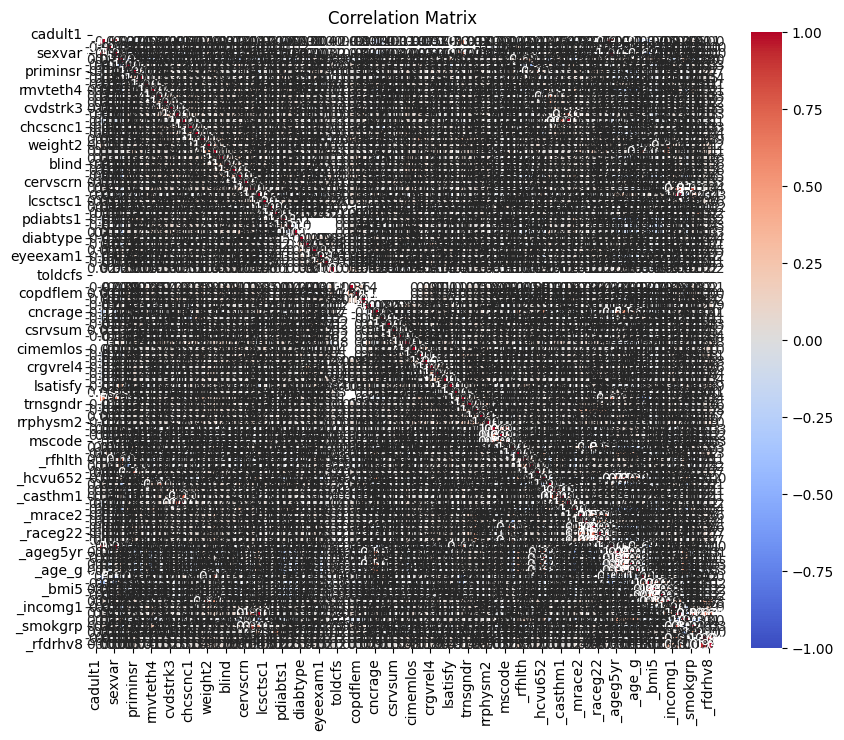

In [14]:
# printing correlation matrix

correlation_matrix = fsm.corr()

plt.figure(figsize=(10, 8))  # Set the size of the plot
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1, fmt='.2f', linewidths=0.5)
plt.title('Correlation Matrix')
plt.show()

Woah!! This is totally uninterpretable. 

Let's try two things:

1) Printing the **pairs of features with the highest correlation** values
2) Using **clustering** to identify **groups of similar features**, and printing smaller corrrelation matrices based on these groups.

#### Printing Pairs of Correlated Features

In [15]:
# Assuming 'fsm' is your DataFrame
correlation_matrix = fsm.corr().abs()  # Take the absolute value to focus on the strength of correlations
np.fill_diagonal(correlation_matrix.values, 0)  # Set diagonal to 0 to ignore self-correlations

# Find the indices of the maximum correlations
high_corr_pairs = correlation_matrix.unstack().sort_values(ascending=False)

# Display the top pairs
print(high_corr_pairs.head(10))

smokday2  _smoker3    0.997373
_smoker3  smokday2    0.997373
_sex      sexvar      0.997272
sexvar    _sex        0.997272
_asthms1  asthnow     0.994266
asthnow   _asthms1    0.994266
_age_g    _age80      0.973894
_age80    _age_g      0.973894
_ageg5yr  _age80      0.964545
_age80    _ageg5yr    0.964545
dtype: float64


Woah! A ton of HIGHLY correlated pairs. Let's print a greater number so we can examine further.

In [16]:
# Assuming 'fsm' is your DataFrame
correlation_matrix = fsm.corr().abs()  # Take the absolute value to focus on the strength of correlations
np.fill_diagonal(correlation_matrix.values, 0)  # Set diagonal to 0 to ignore self-correlations

# Find the indices of the maximum correlations
high_corr_pairs = correlation_matrix.unstack().sort_values(ascending=False)

# Display the top pairs
print(high_corr_pairs.head(50))

smokday2  _smoker3    0.997373
_smoker3  smokday2    0.997373
_sex      sexvar      0.997272
sexvar    _sex        0.997272
_asthms1  asthnow     0.994266
asthnow   _asthms1    0.994266
_age_g    _age80      0.973894
_age80    _age_g      0.973894
_ageg5yr  _age80      0.964545
_age80    _ageg5yr    0.964545
_racegr4  _race1      0.952064
_race1    _racegr4    0.952064
cellsex1  sexvar      0.950968
sexvar    cellsex1    0.950968
cellsex1  _sex        0.948230
_sex      cellsex1    0.948230
_ageg5yr  _age_g      0.942386
_age_g    _ageg5yr    0.942386
_rfbing6  _rfdrhv8    0.939160
_rfdrhv8  _rfbing6    0.939160
_hcvu652  _age65yr    0.916876
_age65yr  _hcvu652    0.916876
_metstat  mscode      0.865803
mscode    _metstat    0.865803
_racegr4  _raceg22    0.861555
_raceg22  _racegr4    0.861555
wtkg3     _bmi5       0.859557
_bmi5     wtkg3       0.859557
_smokgrp  _smoker3    0.856792
_smoker3  _smokgrp    0.856792
_rfbmi5   _bmi5cat    0.854818
_bmi5cat  _rfbmi5     0.854818
        

Wow. Even printing the top 50, as opposed to the top 10, all the features are highly correlated.

We can't move on to **K-Means Clustering** to group features, with so many (or really any) NaNs still in the dataframe. Let's harness domain knowledge from the Codebook to cut down correlated features, then printed correlated pairs again, then move on to clustering if possible.

### Correlated Pairs: Using Codebook

It's clear there are highly interrelated groups of features based on the correlated pairs printed above. Rather than wasting time identifying each of these features and their meaning in a markdown, I'll identify the group "category" (such as 'Smoking Habits'), and refer to the Codebook to identify which select feature(s) from this group will be most useful and why. 

I'll want to print the **number of non-nulls** in addition to the column names, so I can try and try and pick features with less NaN's if possible during my selection. This will help make imputations and cleaning easier to prepare for clustering.

#### Smoking Habits

In [17]:
# Find columns with 'smok' in their names
smok_columns = [col for col in fsm.columns if 'smok' in col.lower()]

# Print column names and their number of non-null values
for col in smok_columns:
    non_null_count = fsm[col].notnull().sum()
    print(f"Column: {col}, Non-null count: {non_null_count}")

Column: smoke100, Non-null count: 413355
Column: smokday2, Non-null count: 164053
Column: _smoker3, Non-null count: 445132
Column: _yrssmok, Non-null count: 147604
Column: _smokgrp, Non-null count: 409670


##### SELECTS TO KEEP: _smokgrp

Survey Question: Smoking Group

Answer Values...

In [18]:
#ADDING TO DICTIONARY CODEBOOK KEY
codebook_key['_smokgrp'] = {
    'Question': 'Smoking Group',
    'Answers': {
    1: 'Current smoker, 20+ Pack Years',
    2: 'Former smoker, 20+ Pack years, quit < 15 years',
    3: 'All other current and former smokers', 
    4: 'Never smoker',
    0: 'Dont know/Refused/Missing'
    }
}

In [19]:
# List of columns to drop
columns_to_drop = ['smoke100', 'smokday2', '_smoker3', '_yrssmok']

# Drop the specified columns
fsm = fsm.drop(columns=columns_to_drop)

# Use .loc to fill NaN values in '_smokgrp' with 0
fsm.loc[:, '_smokgrp'] = fsm['_smokgrp'].fillna(0)

#### Sex Group

In [20]:
# Find columns with 'sex' in their names
sex_columns = [col for col in fsm.columns if 'sex' in col.lower()]

# Print column names and their number of non-null values
for col in sex_columns:
    non_null_count = fsm[col].notnull().sum()
    print(f"Column: {col}, Non-null count: {non_null_count}")

Column: cellsex1, Non-null count: 349079
Column: sexvar, Non-null count: 445132
Column: birthsex, Non-null count: 79427
Column: _sex, Non-null count: 445132


##### SELECTS TO KEEP: _sex

Survey Question: Calculated sex variable

Answer Values...

In [21]:
# ADDING TO DICTIONARY CODEBOOK KEY
codebook_key['_sex']: {
    'Question': 'Calculated sex variable',
    'Answers': {
    1: 'Male',
    2: 'Female',
    }
}

In [22]:
# List of columns to drop
columns_to_drop = ['cellsex1', 'sexvar', 'birthsex']

# Drop the specified columns
fsm = fsm.drop(columns=columns_to_drop)

#### Age Group

In [23]:
# Find columns with 'age' in their names
age_columns = [col for col in fsm.columns if 'age' in col.lower()]

# Print column names and their number of non-null values
for col in age_columns:
    non_null_count = fsm[col].notnull().sum()
    print(f"Column: {col}, Non-null count: {non_null_count}")

Column: cncrage, Non-null count: 22565
Column: _ageg5yr, Non-null count: 445132
Column: _age65yr, Non-null count: 445132
Column: _age80, Non-null count: 445132
Column: _age_g, Non-null count: 445132


##### SELECTS TO KEEP: cncrage, _age_g

##### cncrage

Survey Question: At what age were you told that you had cancer? (If Response = 2 (Two) or 3 (Three or more), ask: “At what age was your first diagnosis of cancer?”)

Answer Values...

In [24]:
# ADDING TO DICTIONARY CODEBOOK KEY
codebook_key['cncrage'] = {
    'Question': 'At what age were you told that you had cancer? (If Response = 2 (Two) or 3 (Three or more), ask: “At what age was your first diagnosis of cancer?”)',
    'Answers': {
    '1-97': 'Age in years (97=97 and older)',
    98: 'Dont know/Not Sure',
    99: 'Refused',
    0: 'Missing'
    }
}

##### _age_g

Survey Question: Six-level imputed age category

Answer Values...

In [25]:
# ADDING TO DICTIONARY CODEBOOK KEY
codebook_key['_age_g'] = {
    'Question': 'Six-level imputed age category',
    'Answers': {
    1: 'Age 18 to 24',
    2: 'Age 25 to 34',
    3: 'Age 35 to 44',
    4: 'Age 45 to 54',
    5: 'Age 55 to 64',
    6: 'Age 65 or older'
    }
}

Adding 'cadult1' to columns to drop by using domain knowledge and referencing codebook.

In [26]:
# List of columns to drop
columns_to_drop = ['_ageg5yr', '_age65yr', '_age80', 'cadult1']

# Drop the specified columns
fsm = fsm.drop(columns=columns_to_drop)

# Use .loc to fill NaN values in 'cncrage' with 0
fsm.loc[:, 'cncrage'] = fsm['cncrage'].fillna(0)

#### Race

In [27]:
# Find columns with 'race' in their names
race_columns = [col for col in fsm.columns if 'race' in col.lower()]

# Print column names and their number of non-null values
for col in race_columns:
    non_null_count = fsm[col].notnull().sum()
    print(f"Column: {col}, Non-null count: {non_null_count}")

Column: _imprace, Non-null count: 445132
Column: _mrace2, Non-null count: 445121
Column: _race1, Non-null count: 445130
Column: _raceg22, Non-null count: 445130
Column: _racegr4, Non-null count: 445130


##### SELECTS TO KEEP: _race1

Survey Question: Race/ethnicity categories

Answer Values...

In [28]:
# ADDING TO DICTIONARY CODEBOOK KEY
codebook_key['_race1'] = {
    'Question': 'Race/ethnicity categories',
    'Answers': {
    1: 'White only, non-Hispanic',
    2: 'Black only, non-Hipsnaic', 
    3: 'American Indian or Alaskan Native only, Non-Hispanic',
    4: 'Asian only, non-Hispanic',
    5: 'Native Hawaiin or other Pacific Islander only, Non-Hispanic',
    7: 'Multiracial, non-Hispanic',
    8: 'Hispanic',
    9: 'Dont know/Not Sure/Refuse',
    0: 'Missing'
    }
}

In [29]:
# List of columns to drop
columns_to_drop = ['_imprace', '_mrace2', '_raceg22', '_racegr4']

# Drop the specified columns
fsm = fsm.drop(columns=columns_to_drop)

# Use .loc to fill NaN values in 'cncrage' with 0
fsm.loc[:, '_race1'] = fsm['_race1'].fillna(0)

#### Height

In [30]:
# Find columns with 'height' or 'ht' in their names
height_columns = [col for col in fsm.columns if 'height' in col.lower() or 'ht' in col.lower()]

# Print column names and their number of non-null values
for col in height_columns:
    non_null_count = fsm[col].notnull().sum()
    print(f"Column: {col}, Non-null count: {non_null_count}")

Column: weight2, Non-null count: 429231
Column: height3, Non-null count: 428077
Column: htin4, Non-null count: 412656


##### SELECTS TO KEEP: height3 

*[ignoring 'weight' column that was included in analysis!]*

Survey Question: About how tall are you without shoes? (If respondent answers in metrics, put a 9 in the first column)

Answer Values...

In [31]:
# ADDING TO DICTIONARY CODEBOOK KEY
codebook_key['height3'] = {
    'Question': 'About how tall are you without shoes? (If respondent answers in metrics, put a 9 in the first column)',
    'Answers': {
    '200-711': 'Height (ft/inches)',
    0: 'Missing',
    'NOTES': '0_/_ _=feet/inches'
    }
}

In [32]:
# List of columns to drop
columns_to_drop = ['htin4']

# Drop the specified columns
fsm = fsm.drop(columns=columns_to_drop)

# Use .loc to fill NaN values in 'cncrage' with 0
fsm.loc[:, 'height3'] = fsm['height3'].fillna(0)

#### Asthma

In [33]:
# Find columns with 'height' or 'ht' in their names
asthma_columns = [col for col in fsm.columns if 'asth' in col.lower()]

# Print column names and their number of non-null values
for col in asthma_columns:
    non_null_count = fsm[col].notnull().sum()
    print(f"Column: {col}, Non-null count: {non_null_count}")

Column: asthma3, Non-null count: 445130
Column: asthnow, Non-null count: 66694
Column: _ltasth1, Non-null count: 445132
Column: _casthm1, Non-null count: 445132
Column: _asthms1, Non-null count: 445132


##### SELECTS TO KEEP: _asthms1

Survey Question: Computed asthma status

Answer Values...

In [34]:
codebook_key['_asthms1'] = {
    'Question': 'Computed asthma status',
    'Answers': {
    1: 'Current',
    2: 'Former',
    3: 'Never',
    9: 'Dont know/Note Sure or Refused/Missing'
    }
}

Adding 'chcscnc1' to columns to drop using domain knowledge and referencing codebook.

In [35]:
# List of columns to drop
columns_to_drop = ['asthma3', 'asthnow', '_ltasth1', '_casthm1', 'chcscnc1']

# Drop the specified columns
fsm = fsm.drop(columns=columns_to_drop)

#### Correlated Pairs

Let's print our Correlated Pairs again, now that we've narrowed focus.

In [36]:
# Assuming 'fsm' is your DataFrame
correlation_matrix = fsm.corr().abs()  # Take the absolute value to focus on the strength of correlations
np.fill_diagonal(correlation_matrix.values, 0)  # Set diagonal to 0 to ignore self-correlations

# Find the indices of the maximum correlations
high_corr_pairs = correlation_matrix.unstack().sort_values(ascending=False)

# Display the top pairs
print(high_corr_pairs.head(50))

_rfbing6  _rfdrhv8    0.939160
_rfdrhv8  _rfbing6    0.939160
_metstat  mscode      0.865803
mscode    _metstat    0.865803
wtkg3     _bmi5       0.859557
_bmi5     wtkg3       0.859557
_rfbmi5   _bmi5cat    0.854818
_bmi5cat  _rfbmi5     0.854818
          _bmi5       0.832352
_bmi5     _bmi5cat    0.832352
_rfbmi5   weight2     0.828977
weight2   _rfbmi5     0.828977
_bmi5cat  wtkg3       0.743352
wtkg3     _bmi5cat    0.743352
_hlthpln  priminsr    0.733702
priminsr  _hlthpln    0.733702
_hcvu652  _age_g      0.684079
_age_g    _hcvu652    0.684079
_rfhlth   genhlth     0.675082
genhlth   _rfhlth     0.675082
_bmi5     _rfbmi5     0.649035
_rfbmi5   _bmi5       0.649035
_urbstat  _metstat    0.624926
_metstat  _urbstat    0.624926
cvdinfr4  _michd      0.596562
_michd    cvdinfr4    0.596562
_rfdrhv8  _smokgrp    0.596060
_smokgrp  _rfdrhv8    0.596060
_rfbing6  _smokgrp    0.585503
_smokgrp  _rfbing6    0.585503
_urbstat  mscode      0.557608
mscode    _urbstat    0.557608
cncrdiff

Still need to cut down some more by category!

#### 'rf'

Let's remind ourselves what 'rf' means.

In [37]:
# Find columns with 'age' in their names
rf_columns = [col for col in fsm.columns if 'rf' in col.lower()]

# Print column names and their number of non-null values
for col in rf_columns:
    non_null_count = fsm[col].notnull().sum()
    print(f"Column: {col}, Non-null count: {non_null_count}")

Column: _rfhlth, Non-null count: 445132
Column: _rfbmi5, Non-null count: 445132
Column: _rfbing6, Non-null count: 445132
Column: _rfdrhv8, Non-null count: 445132


Hmmm...These don't actually seem to be explicitly interrelated:

**_rfhlth**: Adults with good or better health

**_rfbmi5**: Adults who have a body mass index greater than 25.00 (Overweight or Obese)

**_rfbing6**: Binge drinkers (males having five or more drinks on one occasion, females having four or more drinks on one occasion)

**_rfdrhv8**: Heavy drinkers (adult men having more than 14 drinks per week and adult women having more than 7 drinks per week)

The last two having to do with drinking have an overlap of content. But it might be a helpful distinction. Let's leave it for now. 

#### BMI

In [38]:
# Find columns with 'age' in their names
bmi_columns = [col for col in fsm.columns if 'bmi' in col.lower()]

# Print column names and their number of non-null values
for col in bmi_columns:
    non_null_count = fsm[col].notnull().sum()
    print(f"Column: {col}, Non-null count: {non_null_count}")

Column: _bmi5, Non-null count: 396326
Column: _bmi5cat, Non-null count: 396326
Column: _rfbmi5, Non-null count: 445132


##### SELECTS TO KEEP: _bmi5cat

Survey Question: Four-categories of Body Mass Index (BMI)

Answer Values...

In [39]:
# ADDING TO DICTIONARY CODEBOOK KEY
codebook_key['_bmi5cat'] = {
    'Question': 'Four-categories of Body Mass Index (BMI)',
    'Answers': {
    1: 'Underweight',
    2: 'Normal Weight',
    3: 'Overweight',
    4: 'Obese',
    0: 'Dont know/Refused/Missing'
    }
}

Adding 'weight2' and 'wtkg3' to columns to drop using domain knowledge and codebook.

In [40]:
# List of columns to drop
columns_to_drop = ['_bmi5', '_rfbmi5', 'weight2', 'wtkg3']

# Drop the specified columns
fsm = fsm.drop(columns=columns_to_drop)

# Use .loc to fill NaN values in 'cncrage' with 0
fsm.loc[:, '_bmi5cat'] = fsm['_bmi5cat'].fillna(0)

#### Physical/General Health

In [41]:
# Find columns
health_columns = [col for col in fsm.columns if 'hlth' in col.lower() or 'phys' in col.lower()]

# Print column names and their number of non-null values
for col in health_columns:
    non_null_count = fsm[col].notnull().sum()
    print(f"Column: {col}, Non-null count: {non_null_count}")

Column: genhlth, Non-null count: 445129
Column: physhlth, Non-null count: 445127
Column: rrphysm2, Non-null count: 160190
Column: _rfhlth, Non-null count: 445132
Column: _phys14d, Non-null count: 445132
Column: _hlthpln, Non-null count: 445132


##### SELECTS TO KEEP: _rfhlth, _phys14d, priminsr

##### _rfhlth

Survey Question: Adults with good or better health

Answer Values...

In [42]:
# ADDING TO DICTIONARY CODEBOOK KEY
codebook_key['_rfhlth'] = {
    'Question': 'Adults with good or better health',
    'Answers': {
    1: 'Good or Better Health',
    2: 'Fair or Poor Health',
    9: 'Dont know/Not Sure Or Refused/Missing'
    }
}

##### _phys14d

Survey Question: 3 level not good physical health status: 0 days, 1-13 days, 14-30 days

Answer Values...

In [43]:
# ADDING TO DICTIONARY CODEBOOK KEY
codebook_key['_phys14d'] = {
    'Question': '3 level not good physical health status: 0 days, 1-13 days, 14-30 days',
    'Answers': {
    1: 'Zero days when physical health not good',
    2: '1-13 days when physical health not good',
    3: '14+ days when physical health not good',
    9: 'Dont know/Refused/Missing'
    }
}

##### priminsr

**Added to category using domain knowledge/codebook**

Survey Question: What is the current primary source of your health insurance?

Answer Values

In [44]:
codebook_key['priminsr'] = {
    'Question': 'What is the current primary source of your health insurance?',
    'Answers': {
        2: 'A private nongovernmental plan that you or another family member buys on your own',
        3: 'Medicare',
        4: 'Medigap',
        5: 'Medicaid',
        6: 'Childrens Health Insurance Program (CHIP)',
        7: 'Military related health care: TRICARE (CHAMPUS) /VA hleath care/CHAMP-VA',
        8: 'Indian Health Service',
        9: 'State sponsored health plan',
        10: 'Other government program',
        88: 'No coverage of any type',
        77: 'Dont know/Not Sure',
        99: 'Refused',
        0: 'Not asked or Missing'
    }
}

Adding 'persdoc3' to columns to drop using domain knowledge & referencing codebook.

In [45]:
# List of columns to drop
columns_to_drop = ['genhlth', 'physhlth', 'rrphysm2', '_hlthpln', 'persdoc3']

# Drop the specified columns
fsm = fsm.drop(columns=columns_to_drop)

#### Correlated Pairs

In [46]:
# Assuming 'fsm' is your DataFrame
correlation_matrix = fsm.corr().abs()  # Take the absolute value to focus on the strength of correlations
np.fill_diagonal(correlation_matrix.values, 0)  # Set diagonal to 0 to ignore self-correlations

# Find the indices of the maximum correlations
high_corr_pairs = correlation_matrix.unstack().sort_values(ascending=False)

# Display the top pairs
print(high_corr_pairs.head(50))

_rfdrhv8  _rfbing6    0.939160
_rfbing6  _rfdrhv8    0.939160
mscode    _metstat    0.865803
_metstat  mscode      0.865803
_age_g    _hcvu652    0.684079
_hcvu652  _age_g      0.684079
_urbstat  _metstat    0.624926
_metstat  _urbstat    0.624926
cvdinfr4  _michd      0.596562
_michd    cvdinfr4    0.596562
_rfdrhv8  _smokgrp    0.596060
_smokgrp  _rfdrhv8    0.596060
_rfbing6  _smokgrp    0.585503
_smokgrp  _rfbing6    0.585503
_urbstat  mscode      0.557608
mscode    _urbstat    0.557608
cncrdiff  cncrage     0.493274
cncrage   cncrdiff    0.493274
_lcsrec   lcsscncr    0.449605
lcsscncr  _lcsrec     0.449605
_lcsrec   _smokgrp    0.438588
_smokgrp  _lcsrec     0.438588
_michd    cvdcrhd4    0.408870
cvdcrhd4  _michd      0.408870
_drdxar2  _age_g      0.386245
_age_g    _drdxar2    0.386245
eyeexam1  diabeye1    0.380262
diabeye1  eyeexam1    0.380262
cddiscus  pregnant    0.373439
pregnant  cddiscus    0.373439
copdflem  copdcogh    0.362703
copdcogh  copdflem    0.362703
_age_g  

Still a couple high numbers between certain pairs, but this looks much better! We've narrowed down quiete a bit of repetition and overlap between similarly categorized features. 

## Imputing with Placeholder: 0

Let's move to K-Means Clustering, and impute all our missing values with 0 as a placeholder for now, and see how things shake out. 

Looking through the rest of the Codebook, almost none of the rows have '0' as an assigned value. The only times it might cause confusion, is in a feature that asking a certain 'number of times' a behavior was committed (ex. 'How many drinks a week do you have?'), in which 0 could be an answer. 

Let's print all the columns that have '0' as a unique value and see if this pertains to any of them. In which case, we'll have to find another placeholder for missingness. 

In [47]:
# Find columns with '0' as a unique value in any of its rows
columns_with_zero = [col for col in fsm.columns if (fsm[col] == 0).any()]

# Print the columns
print("Columns containing '0' as a unique value:")
for col in columns_with_zero:
    print(col)

Columns containing '0' as a unique value:
height3
cncrage
_race1
_bmi5cat
_smokgrp


Fantastic!! These are all columns that I added '0' to as a placeholder to impute missingness. None of them are the few columns in the Codebook to which I was referring, which use 0 as a real answer value.

All of our columns are numeric ***float*** dtypes, so I know there's no need to check if '0' appears as a string value in any columns as well.

I can go ahead and use 0 as a placeholder for all missingness in the dataframe for this FSM. **For my larger MVP, I'll have to reasses** - when I start adding new columns into the models.

In [48]:
# Impute all NaN values with 0
fsm.fillna(0, inplace=True)

In [49]:
fsm.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 445132 entries, 0 to 445131
Data columns (total 70 columns):
 #   Column    Non-Null Count   Dtype  
---  ------    --------------   -----  
 0   cstate1   445132 non-null  float64
 1   priminsr  445132 non-null  float64
 2   medcost1  445132 non-null  float64
 3   rmvteth4  445132 non-null  float64
 4   cvdinfr4  445132 non-null  float64
 5   cvdcrhd4  445132 non-null  float64
 6   cvdstrk3  445132 non-null  float64
 7   chcocnc1  445132 non-null  float64
 8   pregnant  445132 non-null  float64
 9   height3   445132 non-null  float64
 10  deaf      445132 non-null  float64
 11  blind     445132 non-null  float64
 12  decide    445132 non-null  float64
 13  diffwalk  445132 non-null  float64
 14  cervscrn  445132 non-null  float64
 15  lcsctsc1  445132 non-null  float64
 16  _state    445132 non-null  float64
 17  lcsscncr  445132 non-null  float64
 18  pdiabts1  445132 non-null  float64
 19  prediab2  445132 non-null  float64
 20  diab

Great. Let's use clustering to print a correlation matrix by group.

## Correlated Features: K-Means Clustering

NaNs detected in the correlation matrix.


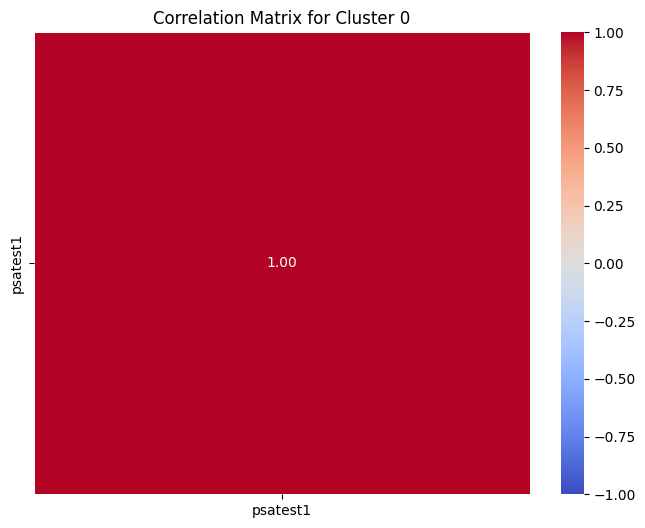

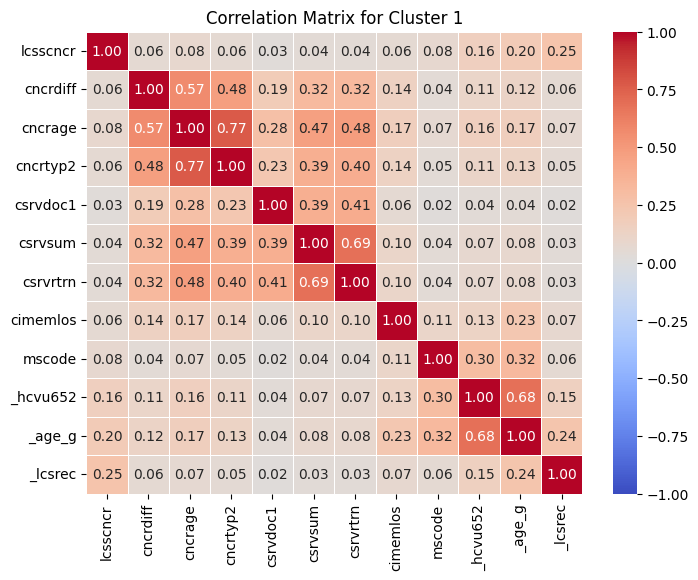

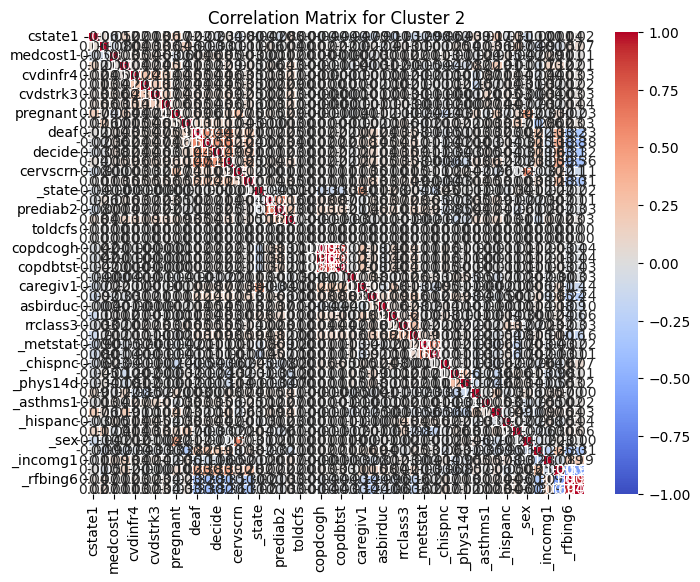

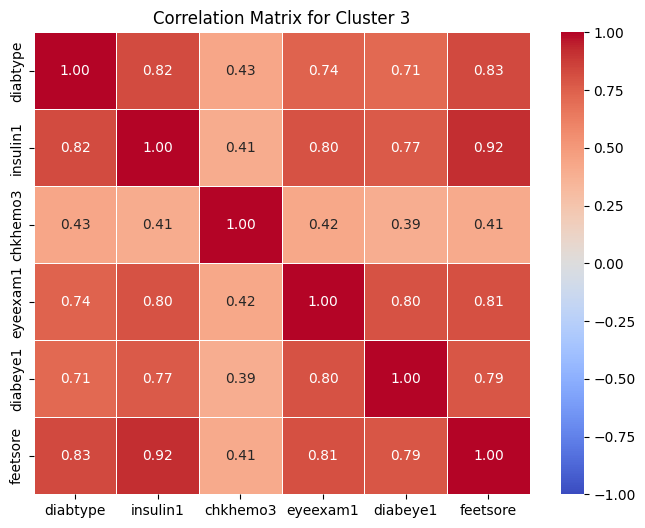

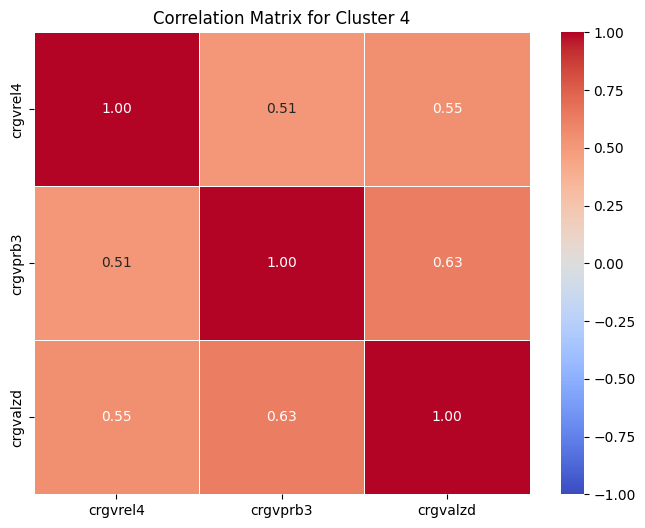

In [50]:
# Compute the correlation matrix
correlation_matrix = fsm.corr()

# Check for NaNs in the correlation matrix
if correlation_matrix.isnull().values.any():
    print("NaNs detected in the correlation matrix.")
    # Impute NaNs with 0 in the correlation matrix
    imputer = SimpleImputer(strategy='constant', fill_value=0)
    correlation_matrix = pd.DataFrame(imputer.fit_transform(correlation_matrix), index=correlation_matrix.index, columns=correlation_matrix.columns)

# Flatten correlation matrix and standardize for clustering
corr_matrix_flat = correlation_matrix.values
scaler = StandardScaler()
scaled_corr_matrix = scaler.fit_transform(corr_matrix_flat)

# Perform K-Means clustering
num_clusters = 5  # Specify the number of clusters
kmeans = KMeans(n_clusters=num_clusters, random_state=0)
clusters = kmeans.fit_predict(scaled_corr_matrix)

# Create a DataFrame with cluster labels for each feature
feature_clusters = pd.DataFrame({
    'Feature': correlation_matrix.columns,
    'Cluster': clusters
})

# Plot correlation matrices for each cluster
for cluster in range(num_clusters):
    # Get features in the current cluster
    cluster_features = feature_clusters[feature_clusters['Cluster'] == cluster]['Feature']
    cluster_corr_matrix = correlation_matrix.loc[cluster_features, cluster_features]
    
    plt.figure(figsize=(8, 6))  # Set the size of the plot
    sns.heatmap(cluster_corr_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1, fmt='.2f', linewidths=0.5)
    plt.title(f'Correlation Matrix for Cluster {cluster}')
    plt.show()

### Feature Clusters

In [51]:
print(feature_clusters)

     Feature  Cluster
0    cstate1        2
1   priminsr        2
2   medcost1        2
3   rmvteth4        2
4   cvdinfr4        2
..       ...      ...
65  _incomg1        2
66  _smokgrp        2
67   _lcsrec        1
68  _rfbing6        2
69  _rfdrhv8        2

[70 rows x 2 columns]


In [52]:
feature_clusters['Cluster'].value_counts()

Cluster
2    48
1    12
3     6
4     3
0     1
Name: count, dtype: int64

In [53]:
# Sort feature_clusters by 'Feature'
sorted_feature_clusters = feature_clusters.sort_values(by=['Feature'])

# Create clusters_summary from the sorted DataFrame
clusters_summary = sorted_feature_clusters.groupby('Cluster')['Feature'].apply(list)

# Loop through each unique cluster and print sorted features
for cluster, features in clusters_summary.items():
    print(f"Cluster {cluster}:")
    for feature in features:
        print(f"  {feature}")
    print()  # Blank line for better readability

Cluster 0:
  psatest1

Cluster 1:
  _age_g
  _hcvu652
  _lcsrec
  cimemlos
  cncrage
  cncrdiff
  cncrtyp2
  csrvdoc1
  csrvrtrn
  csrvsum
  lcsscncr
  mscode

Cluster 2:
  _asthms1
  _bmi5cat
  _chispnc
  _drdxar2
  _hispanc
  _incomg1
  _metstat
  _michd
  _phys14d
  _race1
  _rfbing6
  _rfdrhv8
  _rfhlth
  _sex
  _smokgrp
  _state
  _urbstat
  asbirduc
  blind
  caregiv1
  cddiscus
  cervscrn
  chcocnc1
  copdbtst
  copdcogh
  copdflem
  cstate1
  cvdcrhd4
  cvdinfr4
  cvdstrk3
  deaf
  decide
  diabete4
  diffwalk
  havecfs
  height3
  lcsctsc1
  lsatisfy
  medcost1
  pdiabts1
  prediab2
  pregnant
  priminsr
  rmvteth4
  rrclass3
  rrhcare4
  toldcfs
  trnsgndr

Cluster 3:
  chkhemo3
  diabeye1
  diabtype
  eyeexam1
  feetsore
  insulin1

Cluster 4:
  crgvalzd
  crgvprb3
  crgvrel4



### diabete4 Correlation

Let's check which features are highly correlated with our target variable, diabete4. We can already get a glimpse of this based on which features were included in the same cluster as the target.

In [54]:
# Compute correlation matrix
correlation_matrix = fsm.corr()

# Extract correlations with 'diabete4'
diabete4_corr = correlation_matrix['diabete4'].sort_values(ascending=False)

# Print correlations with 'diabete4'
print("Correlations with 'diabete4':")
print(diabete4_corr.head(30))
print(diabete4_corr.tail(30))

# Filter out the target variable itself (if you don't want to include it)
high_corr_features = diabete4_corr[diabete4_corr.index != 'diabete4']

# Display highly correlated features (e.g., correlation > 0.5 or < -0.5)
high_corr_features = high_corr_features[(high_corr_features > 0.5) | (high_corr_features < -0.5)]
print("\nHighly correlated features with 'diabete4':")
print(high_corr_features)

Correlations with 'diabete4':
diabete4    1.000000
prediab2    0.227082
pdiabts1    0.157076
cvdstrk3    0.128727
rmvteth4    0.126222
_drdxar2    0.114558
diffwalk    0.113518
_michd      0.110260
cvdinfr4    0.109992
chcocnc1    0.099456
pregnant    0.092717
cvdcrhd4    0.085223
cstate1     0.078653
_incomg1    0.072352
_asthms1    0.069113
lcsctsc1    0.050438
deaf        0.049991
blind       0.043298
priminsr    0.038291
decide      0.034720
height3     0.033117
_rfbing6    0.032106
_hispanc    0.026075
_rfdrhv8    0.025682
_smokgrp    0.018150
medcost1    0.018050
rrclass3    0.010136
_race1      0.009945
cervscrn    0.009879
_sex        0.005764
Name: diabete4, dtype: float64
_urbstat   -0.009253
copdcogh   -0.010928
copdflem   -0.011211
lsatisfy   -0.013308
psatest1   -0.013313
csrvsum    -0.014490
csrvrtrn   -0.015286
_metstat   -0.015660
_chispnc   -0.019846
cncrtyp2   -0.021573
cncrdiff   -0.022607
cddiscus   -0.031438
cimemlos   -0.032489
cncrage    -0.032546
mscode     -0.0

##### Change Threshold

Right now, there don't seem to be any features highly correlated with our target. This could change as we continue to drop more from the dataframe. For now, let's set a smaller threshold from 0.5 and -0.5

In [55]:
# Filter out the target variable itself (if you don't want to include it)
high_corr_features = diabete4_corr[diabete4_corr.index != 'diabete4']

# Display highly correlated features (e.g., correlation > 0.5 or < -0.5)
high_corr_features = high_corr_features[(high_corr_features > 0.1) | (high_corr_features < -0.1)]
print("\nHighly correlated features with 'diabete4':")
print(high_corr_features)


Highly correlated features with 'diabete4':
prediab2    0.227082
pdiabts1    0.157076
cvdstrk3    0.128727
rmvteth4    0.126222
_drdxar2    0.114558
diffwalk    0.113518
_michd      0.110260
cvdinfr4    0.109992
_bmi5cat   -0.109473
_rfhlth    -0.122371
_hcvu652   -0.123555
chkhemo3   -0.163754
_age_g     -0.183294
diabeye1   -0.320260
eyeexam1   -0.329582
diabtype   -0.335620
insulin1   -0.371270
feetsore   -0.384525
Name: diabete4, dtype: float64


Breakdown of these features below...by adding their question and answer values to the dictionary codebook key.

In [56]:
# ADDING ONLY FEATURES NOT ALREADY IN DICT

# List of highly correlated feature names in their original order
highly_correlated_features = [
    'prediab2',
    'pdiabts1',
    'cvdstrk3',
    'rmvteth4',
    '_drdxar2',
    'diffwalk',
    '_michd',
    'cvdinfr4',
    '_bmi5cat',
    '_rfhlth',
    '_hcvu652',
    'chkhemo3',
    '_age_g',
    'diabeye1',
    'eyeexam1',
    'diabtype',
    'insulin1',
    'feetsore'
]

# Convert codebook_keys to a set for quick lookup
codebook_keys_set = set(codebook_key.keys())

# Filter features to remove those already in codebook_key, maintaining order
filtered_features = [feature for feature in highly_correlated_features if feature not in codebook_keys_set]

# Print the filtered list
print("Features highly correlated with 'diabete4' but not in codebook_key, in original order:")
print(filtered_features)

Features highly correlated with 'diabete4' but not in codebook_key, in original order:
['prediab2', 'pdiabts1', 'cvdstrk3', 'rmvteth4', '_drdxar2', 'diffwalk', '_michd', 'cvdinfr4', '_hcvu652', 'chkhemo3', 'diabeye1', 'eyeexam1', 'diabtype', 'insulin1', 'feetsore']


In [57]:
# ADDING FEATURE QUESTIONS TO DICTIONARY CODEBOOK KEY

codebook_key['prediab2'] = {
    'Question':  'Has a doctor or other health professional ever told you that you had prediabetes or borderline diabetes? (If “Y es” and respondent is female, ask: “Was this only when you were pregnant?"',
    'Answers': {
        1: 'Yes',
        2: 'Yes, during pregnancy',
        3: 'No',
        7: 'Dont know/Not sure',
        9: 'Refused',
        0: 'Missing',
    }
}

codebook_key['pdiabts1'] = {
    'Question': 'When was the last time you had a blood test for high blood sugar or diabetes by a doctor, nurse, or other health professional?',
    'Answers': {
        1: 'Within the past year (anytime less than 12 months ago)',
        2: 'Within the past 2 years (1 year but less than 2 years)',
        3: 'Within the past 3 years (2 years but less than 3 years)',
        4: 'Within the past 5 years (3 to 4 years but less than 5 years ago)', 
        5: 'Within the past 10 years (5 to 9 years but less than 10 years ago)',
        6: '10 or more years ago',
        7: 'Dont know/Not sure',
        8: 'Never',
        9: 'Refused',
        0: 'Not asked or Missing',
    }
}

codebook_key['cvdstrk3'] = {
    'Question': '(Ever told) (you had) a stroke.',
    'Answers': {
        1: 'Yes',
        2: 'No',
        7: 'Dont know/Not sure',
        9: 'Refused',
        0: 'Not asked or Missing',
    }
}

codebook_key['rmvteth4'] = {
    'Question': 'Not including teeth lost for injury or orthodontics, how many of your permanent teeth have been removed because of tooth decay or gum disease?',
    'Answers': {
        1: '1 to 5',
        2: '6 or more, but not all',
        3: 'All',
        7: 'Dont know/Not sure',
        8: 'None',
        9: 'Refused',
        0: 'Not asked or Missing'
    }
}

codebook_key['_drdxar2'] = {
    'Question': 'Respondents who have had a doctor diagnose them as having some form of arthritis',
    'Answers': {
        1: 'Diagnosed with arthritis',
        2: 'Not diagnosed with arthritis',
        0: 'Dont know/Not Sure/Refused/Missing'
    }
}

codebook_key['diffwalk'] = {
    'Question': 'Do you have serious difficulty walking or climbing stairs?',
    'Answers': {
        1: 'Yes',
        2: 'No',
        7: 'Dont know/Not Sure',
        9: 'Refused',
        0: 'Not asked or Missing'
    }
}

codebook_key['_michd'] = {
    'Question': 'Respondents that have ever reported having coronary heart disease (CHD) or myocardial infarction (MI)',
    'Answers': {
        1: 'Reported having MI or CHD',
        2: 'Did not report having MI or CHD',
        0: 'Not asked or Missing'
    }
}

codebook_key['cvdinfr4'] = {
    'Question': '(Ever told) you had a heart attack, also called a myocardial infarction?',
    'Answers': {
        1: 'Yes',
        2: 'No',
        7: 'Dont know/Not sure',
        9: 'Refused',
        0: 'Not asked or Missing'
    }
}

codebook_key['_hcvu652'] = {
    'Question': 'Respondents aged 18-64 who have any form of health insurance',
    'Answers': {
        1: 'Have some form of health insurance',
        2: 'Do not have any form of health insurance',
        9: 'Dont know/Not Sure, Refused or Missing'
    }
}

codebook_key['chkhemo3'] = {
    'Question': 'About how many times in the past 12 months has a doctor, nurse, or other health professional checked you for A-one-C?',
    'Answers': {
        '1-76': 'Number of times [76=76 or more]',
        '88': 'None',
        'NOTES': '_ _ Number of times, 76 = 76 or more'
    }
}

codebook_key['diabeye1'] = {
    'Question': 'When was the last time a doctor, nurse or other health professional took a photo of the back of your eye with a specialized camera?',
    'Answers': {
        1: 'Within the past month (anytime less than 1 month ago)',
        2: 'Within the past year (1 month but less than 12 months ago)',
        3: 'Within the past 2 years (1 year but less than 2 years ago)',
        4: '2 or more years ago',
        7: 'Dont know/Not sure',
        8: 'Never',
        9: 'Refused',
        0: 'Not asked or Missing'
    }
}

codebook_key['eyeexam1'] = {
    'Question': 'When was the last time you had an eye exam in which the pupils were dilated, making you temporarily sensitive to bright light?',
    'Answers': {
        1: 'Within the past month (anytime less than 1 month ago)',
        2: 'Within the past year (1 month but less than 12 months ago)',
        3: 'Within the past 2 years (1 year but less than 2 years ago)',
        4: '2 or more years ago',
        7: 'Dont know/Not sure',
        8: 'Never',
        9: 'Refused',
        0: 'Not asked or Missing'
    }
}

codebook_key['diabtype'] = {
    'Question': 'According to your doctor or other health professional, what type of diabetes do you have?',
    'Answers': {
        1: 'Type 1',
        2: 'Type 2',
        7: 'Dont know/Not Sure',
        9: 'Refused',
        0: 'Not asked or Missing'
    }
}

codebook_key['insulin1'] = {
    'Question': 'Are you now taking insulin?',
    'Answers': {
        1: 'Yes',
        2: 'No',
        7: 'Dont know/Not Sure',
        9: 'Refused',
        0: 'Not asked or Missing',
    }
}

codebook_key['feetsore'] = {
    'Question': 'Have you ever had any sores or irritations on your feet that took more than four weeks to heal?',
    'Answers': {
        1: 'Yes',
        2: 'No',
        7: 'Dont know/Not sure',
        9: 'Refused',
        0: 'Not asked or MIssing'
    }
}

# Adding 'pregnant' using domain knowledge and codebook


In [58]:
codebook_key

{'diabete4': {'Question': "(Ever told) (you had) diabetes? (If 'Yes' and respondent is female, ask 'Was this only when you were pregnant?´.",
  'Answers': {1: 'Yes',
   2: 'Yes, but female told only during pregnancy',
   3: 'No',
   4: 'No, pre-diabetes or boderline diabetes',
   7: 'Dont know/Not sure',
   9: 'Refused',
   'BLANK': 'Not asked or Missing'}},
 '_smokgrp': {'Question': 'Smoking Group',
  'Answers': {1: 'Current smoker, 20+ Pack Years',
   2: 'Former smoker, 20+ Pack years, quit < 15 years',
   3: 'All other current and former smokers',
   4: 'Never smoker',
   0: 'Dont know/Refused/Missing'}},
 'cncrage': {'Question': 'At what age were you told that you had cancer? (If Response = 2 (Two) or 3 (Three or more), ask: “At what age was your first diagnosis of cancer?”)',
  'Answers': {'1-97': 'Age in years (97=97 and older)',
   98: 'Dont know/Not Sure',
   99: 'Refused',
   0: 'Missing'}},
 '_age_g': {'Question': 'Six-level imputed age category',
  'Answers': {1: 'Age 18 to 

In [59]:
# _hcvu652

## Symptoms vs Predictors

There are clearly some medical features that are symptoms & treatments of diabetes that has already been diagnosed and/or progressed, rather than predictive warning signs of other medical ailments that could eventually lead to diabetes.

For example -- 'insulin1': 'Are you now taking insulin?"; and 'feetsore': Have you ever had any sores or irritiations on your feet that took more than four weeks to heal?' are attributes that a person who already has diabetes (whether knowingly or unknowingly) is very likely to posess. For this FSM, I'm looking for genetic and medical factors that are likely to have existed before someones awareness of their diabetes, that might have helped cause it.

We need to drop these as well. They might be helpful to bring back after our final FSM results to contextualize our findings. We'll group them into a new dataframe 'symptoms', to keep track of them.

Let's go through all the remaining features in out dataframe, that have not yet been updloaded to codebook_key...to make sure we've covered all of our bases. There might be too many to add the rest of them to the dictionary right now, but I'll highlight anyones that are relevant.

#### Symptoms/Effects: insulin1, feetsore, diabtype, diabeye1, pdiabts1, 

In [60]:
# Columns to move
columns_to_move = ['insulin1', 'feetsore', 'diabtype', 'diabeye1', 'pdiabts1']

# Create new DataFrame with the specified columns
symptoms = fsm[columns_to_move].copy()

# Drop these columns from the original DataFrame
fsm = fsm.drop(columns=columns_to_move)

In [61]:
fsm_columns = fsm.keys()
codebook_columns = codebook_key.keys()

# Find columns in fsm that are not in codebook
missing_columns = [col for col in fsm_columns if col not in codebook_columns]

# Print the missing columns
print("Columns in 'fsm' that are NOT in 'codebook':")
for col in missing_columns:
    print(col)

Columns in 'fsm' that are NOT in 'codebook':
cstate1
medcost1
cvdcrhd4
chcocnc1
pregnant
deaf
blind
decide
cervscrn
lcsctsc1
_state
lcsscncr
toldcfs
havecfs
copdcogh
copdflem
copdbtst
cncrdiff
cncrtyp2
csrvdoc1
csrvsum
csrvrtrn
psatest1
cimemlos
cddiscus
caregiv1
crgvrel4
crgvprb3
crgvalzd
lsatisfy
asbirduc
trnsgndr
rrclass3
rrhcare4
_metstat
_urbstat
mscode
_chispnc
_hispanc
_sex
_incomg1
_lcsrec
_rfbing6
_rfdrhv8


There aren't any other features above that should be included in our new 'symptoms' category. We'll just include the features initially outlined and already moved to 'symptoms'.

## Dropping Features

As I went through the features above in the codebook, I found a few more that we can drop due to irrelvancy, or more organized features of an identical category already existing in the dataframe.

In [62]:
# Dropping irrelvant columns
columns_to_drop = ['cstate1', 'csrvrtrn', 'csrvsum', 'cddiscus', 'caregiv1', 'crgvalzd', 'rrclass3', '_urbstat', '_metstat', '_chispnc',
                  'toldcfs', 'havecfs']

# Drop the specified columns
fsm = fsm.drop(columns=columns_to_drop)

## Cleaning/Simplification/Consolidation

I've tried to get a baseline model to run, but unsuprisingly it's taking uncessarily wrong because the dataset is still unecessarily complex. There's further cleaning to be done to help this!

### 'Dont know/Not Sure, Refused or Missing' : 0

For example...right now there's no uniformity to the way blank data is categorized. In some columns, 'Dont know', 'Not sure', 'Refused', 'Missing' and 'BLANK' all fall under one designated answer values. In others, they fall under separate values. In some columns these are all given a value of '9' as designated by the original codebook, in others they're imputed by myself with a value of 0.

9 is sometimes used as a real value in other answers, and is not a uniform imputation for missingness across the entire dataset. I'm going to stick with **0** for now as a uniform placeholder designation, and be on the lookout for the few columns that use 0 as an actual value, as previously stated.

I'm also going to **Combine Dont know, Not Sure, Refused, Missing, and Blank** under one category. This isn't a psychological study, it's a study to determine concrete predictors of diabetes. Therefore the nuances of why certain people might not know or might refuse to answer questions about their health is irrelevant for us, and is equivalent to missingness. 

Let's **convert everything first back to *NaN***, to get an accurate picture of what our dataframe looks like with these answer values combined. Then I can impute all the NaNs back to 0. 

I could try and write code off of the codebook_key dictionary alone, but not all of the columns have been included in this dictionary yet and it honestly might be faster for this particular task to perform a combination of referencing the codebook, the notebook markdowns, and the codebook_key dictionary all at the same time.

In [63]:
codebook_key

{'diabete4': {'Question': "(Ever told) (you had) diabetes? (If 'Yes' and respondent is female, ask 'Was this only when you were pregnant?´.",
  'Answers': {1: 'Yes',
   2: 'Yes, but female told only during pregnancy',
   3: 'No',
   4: 'No, pre-diabetes or boderline diabetes',
   7: 'Dont know/Not sure',
   9: 'Refused',
   'BLANK': 'Not asked or Missing'}},
 '_smokgrp': {'Question': 'Smoking Group',
  'Answers': {1: 'Current smoker, 20+ Pack Years',
   2: 'Former smoker, 20+ Pack years, quit < 15 years',
   3: 'All other current and former smokers',
   4: 'Never smoker',
   0: 'Dont know/Refused/Missing'}},
 'cncrage': {'Question': 'At what age were you told that you had cancer? (If Response = 2 (Two) or 3 (Three or more), ask: “At what age was your first diagnosis of cancer?”)',
  'Answers': {'1-97': 'Age in years (97=97 and older)',
   98: 'Dont know/Not Sure',
   99: 'Refused',
   0: 'Missing'}},
 '_age_g': {'Question': 'Six-level imputed age category',
  'Answers': {1: 'Age 18 to 

In [64]:
fsm.keys()

Index(['priminsr', 'medcost1', 'rmvteth4', 'cvdinfr4', 'cvdcrhd4', 'cvdstrk3',
       'chcocnc1', 'pregnant', 'height3', 'deaf', 'blind', 'decide',
       'diffwalk', 'cervscrn', 'lcsctsc1', '_state', 'lcsscncr', 'prediab2',
       'diabete4', 'chkhemo3', 'eyeexam1', 'copdcogh', 'copdflem', 'copdbtst',
       'cncrdiff', 'cncrage', 'cncrtyp2', 'csrvdoc1', 'psatest1', 'cimemlos',
       'crgvrel4', 'crgvprb3', 'lsatisfy', 'asbirduc', 'trnsgndr', 'rrhcare4',
       'mscode', '_rfhlth', '_phys14d', '_hcvu652', '_michd', '_asthms1',
       '_drdxar2', '_hispanc', '_race1', '_sex', '_age_g', '_bmi5cat',
       '_incomg1', '_smokgrp', '_lcsrec', '_rfbing6', '_rfdrhv8'],
      dtype='object')

In [65]:
fsm.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 445132 entries, 0 to 445131
Data columns (total 53 columns):
 #   Column    Non-Null Count   Dtype  
---  ------    --------------   -----  
 0   priminsr  445132 non-null  float64
 1   medcost1  445132 non-null  float64
 2   rmvteth4  445132 non-null  float64
 3   cvdinfr4  445132 non-null  float64
 4   cvdcrhd4  445132 non-null  float64
 5   cvdstrk3  445132 non-null  float64
 6   chcocnc1  445132 non-null  float64
 7   pregnant  445132 non-null  float64
 8   height3   445132 non-null  float64
 9   deaf      445132 non-null  float64
 10  blind     445132 non-null  float64
 11  decide    445132 non-null  float64
 12  diffwalk  445132 non-null  float64
 13  cervscrn  445132 non-null  float64
 14  lcsctsc1  445132 non-null  float64
 15  _state    445132 non-null  float64
 16  lcsscncr  445132 non-null  float64
 17  prediab2  445132 non-null  float64
 18  diabete4  445132 non-null  float64
 19  chkhemo3  445132 non-null  float64
 20  eyee

In [66]:
# Replace 0 values with NaN
fsm.replace(0, np.nan, inplace=True)

# Replace blank values with NaN
fsm.replace('', np.nan, inplace=True)

In [67]:
# List of columns to update
columns_to_update = ['priminsr', 'chkhemo3', 'cncrtyp2', 'csrvdoc1', 'crgvrel4', 'crgvprb3']

# Replace 77.0 and 99.0 with NaN for specified columns
fsm[columns_to_update] = fsm[columns_to_update].replace({77.0: np.nan, 99.0: np.nan})

# Replace 98.0 and 99.0 with NaN in the 'cncrage' column
fsm['cncrage'] = fsm['cncrage'].replace({98.0: np.nan, 99.0: np.nan})

# Replace 7777.0 and 9999.0 with NaN in the 'height3' column
fsm['height3'] = fsm['height3'].replace({7777.0: np.nan, 9999.0: np.nan})

# List of columns to update
columns_to_update = [
    '_rfhlth', '_phys14d', '_hcvu652', '_asthms1', 
    '_hispanc', '_race1', '_incomg1', '_rfbing6', '_rfdrhv8'
]

# Replace 9.0 with NaN for specified columns
fsm[columns_to_update] = fsm[columns_to_update].replace(9.0, np.nan)

# List of columns to update
columns_to_update = [
    'medcost1', 'rmvteth4', 'cvdinfr4', 'cvdcrhd4', 'cvdstrk3',
    'chcocnc1', 'pregnant', 'deaf', 'blind', 'decide', 'diffwalk',
    'cervscrn', 'lcsctsc1', 'lcsscncr', 'prediab2', 'diabete4',
    'eyeexam1', 'copdcogh', 'copdflem', 'copdbtst', 'cncrdiff',
    'psatest1', 'cimemlos', 'lsatisfy', 'asbirduc', 'trnsgndr',
    'rrhcare4'
]

# Replace 7.0 and 9.0 with NaN for specified columns
fsm[columns_to_update] = fsm[columns_to_update].replace({7.0: np.nan, 9.0: np.nan})

In [68]:
# Get non-null counts for each column
non_null_counts = fsm.notnull().sum()

# Sort columns by non-null counts in ascending order
sorted_columns = non_null_counts.sort_values().index

# Reorder DataFrame columns based on sorted order
fsm_sorted = fsm[sorted_columns]

# Print info of the sorted DataFrame
print(fsm_sorted.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 445132 entries, 0 to 445131
Data columns (total 53 columns):
 #   Column    Non-Null Count   Dtype  
---  ------    --------------   -----  
 0   psatest1  6631 non-null    float64
 1   copdbtst  7125 non-null    float64
 2   copdflem  7228 non-null    float64
 3   copdcogh  7235 non-null    float64
 4   csrvdoc1  9525 non-null    float64
 5   chkhemo3  11887 non-null   float64
 6   eyeexam1  12320 non-null   float64
 7   crgvprb3  18434 non-null   float64
 8   crgvrel4  19380 non-null   float64
 9   cncrage   21413 non-null   float64
 10  cncrtyp2  21592 non-null   float64
 11  cncrdiff  22583 non-null   float64
 12  asbirduc  45944 non-null   float64
 13  _lcsrec   51453 non-null   float64
 14  cimemlos  63948 non-null   float64
 15  pregnant  78480 non-null   float64
 16  mscode    93886 non-null   float64
 17  prediab2  139513 non-null  float64
 18  rrhcare4  139938 non-null  float64
 19  lcsscncr  155937 non-null  float64
 20  cerv

### Answer Value Consolidation

We can further simplify some of our answer values by grouping their meanings into simpler, fewer categories. 

#### 'crgvrel4', 'crgvprb3'

For example, 'crgvrel4' is Survey Question 'What is his or her relationship to you' regarding whether a person provides a caretaking role for another ill person.

I'm including this column to be able to identify whether there are any genetic diseases a person could inherity from close biological family members, such as birth parents. This column currently has 17 different unique values, such as 'Live-in partner', 'non-relative/family friend', 'father-in-law', etc. 

I can consolidate these answers into two simple categories 'Immediate Family' and 'Other'. Then I can use these new simplified values to alter the column **'crgvprb3'**, which identifies 'What is the main health problem, long-term illness, or disability that the person you care for has?', and have it only include rows where the person is **caring for an immediate family member**. Then I can drop/NaN all irrelevant information.

For 'crgvrel4', I'll classify *immediate family* as *mother, father, grandmother, or grandfather*.

In [69]:
# 1 for immediate family member, 0 for other
# Update 'crgvrel4' based on specified conditions
fsm['crgvrel4'] = fsm['crgvrel4'].apply(lambda x: 1 if x in [1, 2, 11, 12] else 0)

In [70]:
# Set 'crgvprb3' to 0 where 'crgvrel4' is 0
fsm.loc[fsm['crgvrel4'] == 0, 'crgvprb3'] = 0

In [71]:
# UPDATING CODEBOOK DICTIONARY KEY
codebook_key['crgvprb3'] = {
    'Question': 'What is the main health problem, long-term illness, or disability that the immediate family member you care for has?',
    'Answer': {
        1: 'Arthritis/ rheumatism',
        2: 'Asthma',
        3: 'Cancer',
        4: 'Chronic respiratory conditions such as emphysema or COPD',
        5: 'Alzheimers disease, dementia or other cognitive impairment disorder',
        6: 'Developmental disabilities such as autism, Downs Syndrome, and spinabifida',
        7: 'Diabetes',
        8: 'Heart disease, hypertension, stroke',
        9: 'Human Immunodeficiency Virus Infection (H.I.V.)',
        10: 'Mental illnesses, such as anxiety, depression, or schizophrenia',
        11: 'Other organ failure or diseases such as kidney or liver problems',
        12: 'Substance abuse or addiction disorders',
        13: 'Injuries, including broken bones',
        14: 'Old age/ infirmity/frailty',
        15: 'Other',
        0: 'Dont know/Not Sure/Refused/Not asked or Missing'
    }
}

In [72]:
# Drop the 'crgvrel4' column
fsm = fsm.drop(columns=['crgvrel4'])

#### cncrage

'cncrage' asks Survey Question 'At what age were you told that you had cancer?' with answer values ranging between 1-97. 

According to the ***National Cancer Institute***, 'advancing age is the most important risk factor for cancer overall'. To use this column to help determine whether a cancer is most likely due to the risk of age, VS. other genetic factors...Let's give this column two different values depending on whether or not the person was diagnosed with cancer ***before or after the median age of a cancer diagnosis: 66 years old***. 

We'll then change the meaning of this column to instead be 'Were you told you had cancer below the median age?', with 1 being 'Yes' and '2' being No.

In [73]:
# Update 'cncrage' based on specified conditions
fsm['cncrage'] = np.where(fsm['cncrage'] >= 1, 
                         np.where(fsm['cncrage'] < 66, 1, 2), 
                         fsm['cncrage'])

In [74]:
fsm.keys()

Index(['priminsr', 'medcost1', 'rmvteth4', 'cvdinfr4', 'cvdcrhd4', 'cvdstrk3',
       'chcocnc1', 'pregnant', 'height3', 'deaf', 'blind', 'decide',
       'diffwalk', 'cervscrn', 'lcsctsc1', '_state', 'lcsscncr', 'prediab2',
       'diabete4', 'chkhemo3', 'eyeexam1', 'copdcogh', 'copdflem', 'copdbtst',
       'cncrdiff', 'cncrage', 'cncrtyp2', 'csrvdoc1', 'psatest1', 'cimemlos',
       'crgvprb3', 'lsatisfy', 'asbirduc', 'trnsgndr', 'rrhcare4', 'mscode',
       '_rfhlth', '_phys14d', '_hcvu652', '_michd', '_asthms1', '_drdxar2',
       '_hispanc', '_race1', '_sex', '_age_g', '_bmi5cat', '_incomg1',
       '_smokgrp', '_lcsrec', '_rfbing6', '_rfdrhv8'],
      dtype='object')

### Correlated Features: K-Means Clustering

Let's try printing clusters of correlated features again, now that we've narrowed focus.

NaNs detected in the correlation matrix.


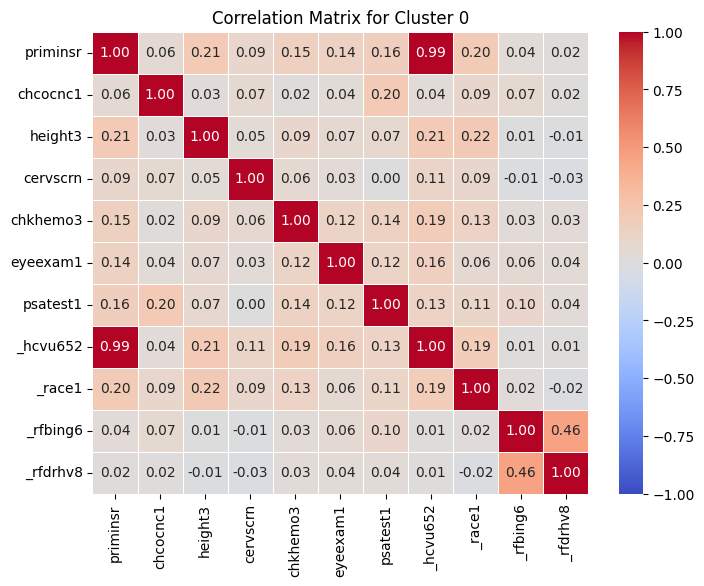

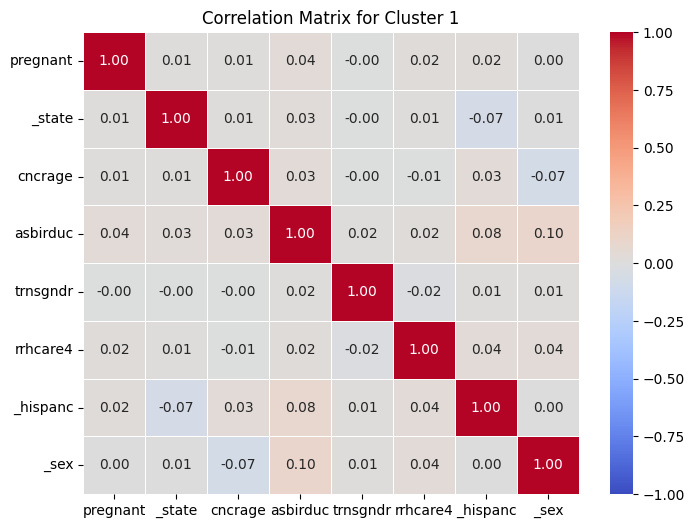

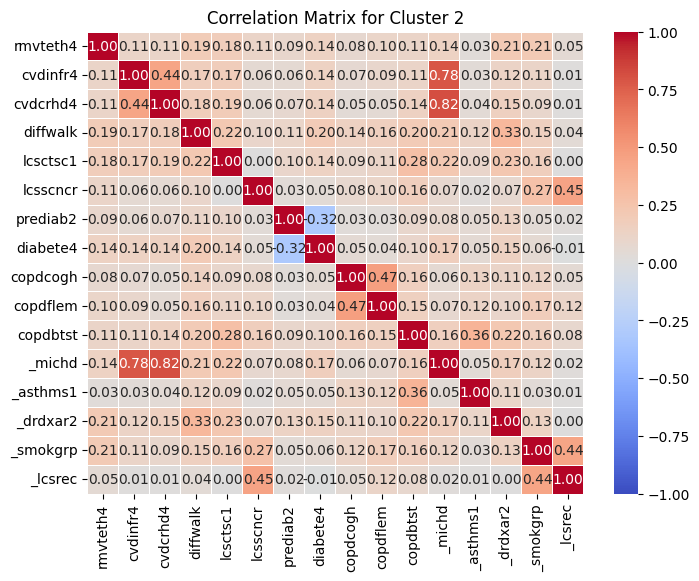

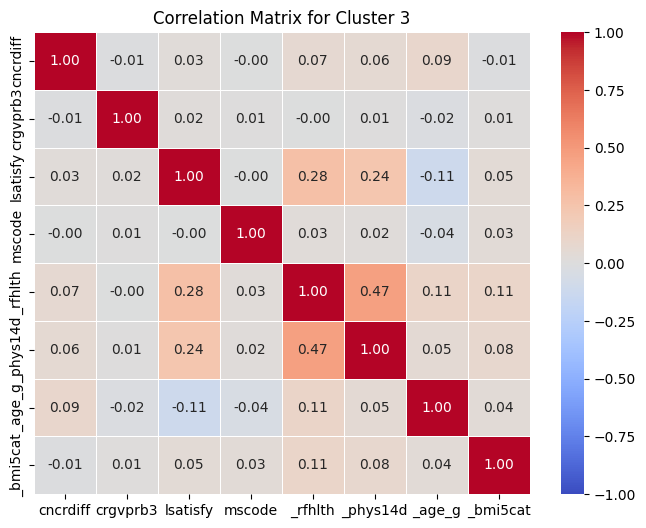

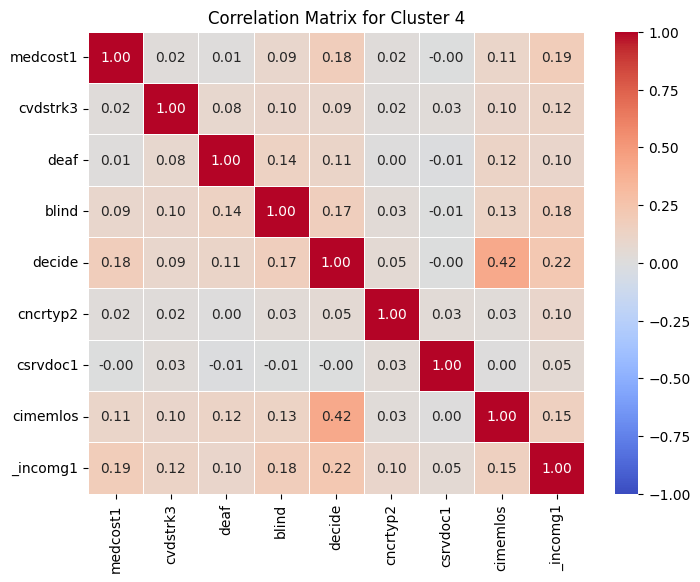

In [75]:
# Compute the correlation matrix
correlation_matrix = fsm.corr()

# Check for NaNs in the correlation matrix
if correlation_matrix.isnull().values.any():
    print("NaNs detected in the correlation matrix.")
    # Impute NaNs with 0 in the correlation matrix
    imputer = SimpleImputer(strategy='constant', fill_value=0)
    correlation_matrix = pd.DataFrame(imputer.fit_transform(correlation_matrix), index=correlation_matrix.index, columns=correlation_matrix.columns)

# Flatten correlation matrix and standardize for clustering
corr_matrix_flat = correlation_matrix.values
scaler = StandardScaler()
scaled_corr_matrix = scaler.fit_transform(corr_matrix_flat)

# Perform K-Means clustering
num_clusters = 5  # Specify the number of clusters
kmeans = KMeans(n_clusters=num_clusters, random_state=0)
clusters = kmeans.fit_predict(scaled_corr_matrix)

# Create a DataFrame with cluster labels for each feature
feature_clusters = pd.DataFrame({
    'Feature': correlation_matrix.columns,
    'Cluster': clusters
})

# Plot correlation matrices for each cluster
for cluster in range(num_clusters):
    # Get features in the current cluster
    cluster_features = feature_clusters[feature_clusters['Cluster'] == cluster]['Feature']
    cluster_corr_matrix = correlation_matrix.loc[cluster_features, cluster_features]
    
    plt.figure(figsize=(8, 6))  # Set the size of the plot
    sns.heatmap(cluster_corr_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1, fmt='.2f', linewidths=0.5)
    plt.title(f'Correlation Matrix for Cluster {cluster}')
    plt.show()

In [76]:
# Sort feature_clusters by 'Feature'
sorted_feature_clusters = feature_clusters.sort_values(by=['Feature'])

# Create clusters_summary from the sorted DataFrame
clusters_summary = sorted_feature_clusters.groupby('Cluster')['Feature'].apply(list)

# Loop through each unique cluster and print sorted features
for cluster, features in clusters_summary.items():
    print(f"Cluster {cluster}:")
    for feature in features:
        print(f"  {feature}")
    print()  # Blank line for better readability

Cluster 0:
  _hcvu652
  _race1
  _rfbing6
  _rfdrhv8
  cervscrn
  chcocnc1
  chkhemo3
  eyeexam1
  height3
  priminsr
  psatest1

Cluster 1:
  _hispanc
  _sex
  _state
  asbirduc
  cncrage
  pregnant
  rrhcare4
  trnsgndr

Cluster 2:
  _asthms1
  _drdxar2
  _lcsrec
  _michd
  _smokgrp
  copdbtst
  copdcogh
  copdflem
  cvdcrhd4
  cvdinfr4
  diabete4
  diffwalk
  lcsctsc1
  lcsscncr
  prediab2
  rmvteth4

Cluster 3:
  _age_g
  _bmi5cat
  _phys14d
  _rfhlth
  cncrdiff
  crgvprb3
  lsatisfy
  mscode

Cluster 4:
  _incomg1
  blind
  cimemlos
  cncrtyp2
  csrvdoc1
  cvdstrk3
  deaf
  decide
  medcost1



#### Highly correlated with diabete4

In [77]:
# Compute correlation matrix
correlation_matrix = fsm.corr()

# Extract correlations with 'diabete4'
diabete4_corr = correlation_matrix['diabete4'].sort_values(ascending=False)

# Print correlations with 'diabete4'
print("Correlations with 'diabete4':")
print(diabete4_corr.head(30))
print(diabete4_corr.tail(30))

# Filter out the target variable itself (if you don't want to include it)
high_corr_features = diabete4_corr[diabete4_corr.index != 'diabete4']

# Display highly correlated features (e.g., correlation > 0.5 or < -0.5)
high_corr_features = high_corr_features[(high_corr_features > 0.5) | (high_corr_features < -0.5)]
print("\nHighly correlated features with 'diabete4':")
print(high_corr_features)

Correlations with 'diabete4':
diabete4    1.000000
diffwalk    0.196517
_michd      0.165560
_drdxar2    0.147681
cvdcrhd4    0.144822
cvdinfr4    0.138707
lcsctsc1    0.137771
rmvteth4    0.136906
_incomg1    0.122792
cvdstrk3    0.104286
copdbtst    0.100460
_rfbing6    0.084878
blind       0.082776
deaf        0.079653
cimemlos    0.073452
chcocnc1    0.062525
psatest1    0.060641
_smokgrp    0.057252
_rfdrhv8    0.057252
_asthms1    0.050941
copdcogh    0.048386
decide      0.048069
lcsscncr    0.046665
copdflem    0.041568
rrhcare4    0.035724
cncrtyp2    0.032290
priminsr    0.032157
_hcvu652    0.024887
height3     0.015850
csrvdoc1    0.014055
Name: diabete4, dtype: float64
lcsscncr    0.046665
copdflem    0.041568
rrhcare4    0.035724
cncrtyp2    0.032290
priminsr    0.032157
_hcvu652    0.024887
height3     0.015850
csrvdoc1    0.014055
_sex        0.009105
crgvprb3    0.008828
mscode      0.007762
asbirduc    0.003659
_hispanc   -0.000122
medcost1   -0.000581
trnsgndr   -0.0

In [78]:
# Filter out the target variable itself (if you don't want to include it)
high_corr_features = diabete4_corr[diabete4_corr.index != 'diabete4']

# Display highly correlated features (e.g., correlation > 0.5 or < -0.5)
high_corr_features = high_corr_features[(high_corr_features > 0.1) | (high_corr_features < -0.1)]
print("\nHighly correlated features with 'diabete4':")
print(high_corr_features)


Highly correlated features with 'diabete4':
diffwalk    0.196517
_michd      0.165560
_drdxar2    0.147681
cvdcrhd4    0.144822
cvdinfr4    0.138707
lcsctsc1    0.137771
rmvteth4    0.136906
_incomg1    0.122792
cvdstrk3    0.104286
copdbtst    0.100460
_phys14d   -0.128386
_bmi5cat   -0.163837
_age_g     -0.193188
_rfhlth    -0.206651
prediab2   -0.320197
Name: diabete4, dtype: float64


#### No Correlation with diabete4

Let's print the features that have the least correlation in either the positive or negative direction with our target. We might consider dropping these, depending on how well (or not well) our model runs.

However, low correlation doesn't necessarily mean anything. **If the relationships are non-linear, the numbers below will not help us**.

In [79]:
# Compute the correlation matrix
correlation_matrix = fsm.corr()

# Extract correlations with 'diabete4'
diabete4_corr = correlation_matrix['diabete4']

# Filter features with correlation less than 0.1 but greater than -0.1
filtered_corr = diabete4_corr[(diabete4_corr < 0.1) & (diabete4_corr > -0.1)]

# Sort the filtered correlations in ascending order
sorted_corr = filtered_corr.sort_values(ascending=True)

# Print feature names and their correlation values
print("Features with correlation to 'diabete4' between -0.1 and 0.1 (sorted in ascending order):")
for feature, corr_value in sorted_corr.items():
    print(f"{feature}: {corr_value:.4f}")

Features with correlation to 'diabete4' between -0.1 and 0.1 (sorted in ascending order):
lsatisfy: -0.0504
cncrdiff: -0.0305
cncrage: -0.0273
cervscrn: -0.0172
pregnant: -0.0074
_lcsrec: -0.0058
_race1: -0.0050
_state: -0.0048
trnsgndr: -0.0042
medcost1: -0.0006
_hispanc: -0.0001
asbirduc: 0.0037
mscode: 0.0078
crgvprb3: 0.0088
_sex: 0.0091
csrvdoc1: 0.0141
height3: 0.0159
_hcvu652: 0.0249
priminsr: 0.0322
cncrtyp2: 0.0323
rrhcare4: 0.0357
copdflem: 0.0416
lcsscncr: 0.0467
decide: 0.0481
copdcogh: 0.0484
_asthms1: 0.0509
_rfdrhv8: 0.0573
_smokgrp: 0.0573
psatest1: 0.0606
chcocnc1: 0.0625
cimemlos: 0.0735
deaf: 0.0797
blind: 0.0828
_rfbing6: 0.0849


# Modeling - Prepping Target

There are so few NaNs in our target variable, diabete4, let's just drop those rows altogether.

In [80]:
# Drop rows where 'diabete4' is NaN
fsm = fsm.dropna(subset=['diabete4'])

In [81]:
# Impute all NaN values with 0
fsm = fsm.fillna(0)

## Binary Classification

Let's double check our value counts to make sure we're running a baseline model that only determines whether someone does or does not have diabetes.

In [82]:
fsm['diabete4'].value_counts()

diabete4
3.0    368722
1.0     61158
4.0     10329
2.0      3836
Name: count, dtype: int64

4 possible values in our target class. Let's use our codebook key dictionary to remind ourselves what they are, then keep only the concrete 'Yes' or 'No'.

In [83]:
codebook_key

{'diabete4': {'Question': "(Ever told) (you had) diabetes? (If 'Yes' and respondent is female, ask 'Was this only when you were pregnant?´.",
  'Answers': {1: 'Yes',
   2: 'Yes, but female told only during pregnancy',
   3: 'No',
   4: 'No, pre-diabetes or boderline diabetes',
   7: 'Dont know/Not sure',
   9: 'Refused',
   'BLANK': 'Not asked or Missing'}},
 '_smokgrp': {'Question': 'Smoking Group',
  'Answers': {1: 'Current smoker, 20+ Pack Years',
   2: 'Former smoker, 20+ Pack years, quit < 15 years',
   3: 'All other current and former smokers',
   4: 'Never smoker',
   0: 'Dont know/Refused/Missing'}},
 'cncrage': {'Question': 'At what age were you told that you had cancer? (If Response = 2 (Two) or 3 (Three or more), ask: “At what age was your first diagnosis of cancer?”)',
  'Answers': {'1-97': 'Age in years (97=97 and older)',
   98: 'Dont know/Not Sure',
   99: 'Refused',
   0: 'Missing'}},
 '_age_g': {'Question': 'Six-level imputed age category',
  'Answers': {1: 'Age 18 to 

##### 2: Only during pregnancy

Let's drop 'Yes, but female told only during pregnancy' for now, since we can assume the direct cause and we need to make our models even simpler to be able to run for our FSM. We can always add this in later if we want to make the model more complex.

In [84]:
# Filetering for only yes or no
filtered = fsm[fsm['diabete4'].isin([1, 3])]

# Multinomial Naive Bayes Classifier

Logistic Regression is having problems running. Multinomial Naive Bayes usually runs faster on larger datasets. Let's try that one first.

### Train Test Split

In [85]:
X = filtered.drop(columns=['diabete4'])
y = filtered['diabete4']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

#### Class Imbalance: SMOTE

Our class imbalance is severe enough, and this is a binary classification problem, so we'll use SMOTE to handle class imbalance.

In [86]:
y_train.value_counts(normalize=True)

diabete4
3.0    0.85796
1.0    0.14204
Name: proportion, dtype: float64

from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import GridSearchCV, train_test_split
from joblib import parallel_backend
from sklearn.metrics import classification_report

# Assuming 'filtered' DataFrame is already defined
X = filtered.drop(columns=['diabete4'])
y = filtered['diabete4']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Define the pipeline with SMOTE and MultinomialNB
pipeline = Pipeline([
    ('smote', SMOTE(random_state=42)),
    ('mnb', MultinomialNB())
])

# Define the parameter grid
param_grid = {
    'mnb__alpha': [0.01, 0.1, 1, 10],
    'mnb__fit_prior': [True, False]
}

# Initialize GridSearchCV with recall as the scoring metric
with parallel_backend('loky'):
    grid_search = GridSearchCV(
        estimator=pipeline,
        param_grid=param_grid,
        cv=5,
        scoring='recall_weighted',  # Use recall as the primary metric
        n_jobs=-1,  # Use all available cores
        verbose=1  # Print progress
    )

    # Fit GridSearchCV
    grid_search.fit(X_train, y_train)

    # Print best parameters and best score
    print(f"Best parameters: {grid_search.best_params_}")
    print(f"Best recall score: {grid_search.best_score_:.4f}")

    # Evaluate on test data
    y_pred = grid_search.best_estimator_.predict(X_test)
    print(classification_report(y_test, y_pred))

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import recall_score, classification_report
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline
from joblib import parallel_backend

# Example DataFrame 'filtered' (replace this with your actual DataFrame)
# filtered = pd.read_csv('your_data.csv')  # Load your dataset

# Define your target variable
target = 'diabete4'  # Replace with your actual target variable name

# Separate features and target variable
X = filtered.drop(columns=[target])
y = filtered[target]

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Check class distribution
print("Class distribution in training set:")
print(y_train.value_counts())

# Adjust SMOTE parameters if needed
smote = SMOTE(sampling_strategy='auto', k_neighbors=min(5, y_train.value_counts().min() - 1), random_state=42)

# Define the pipeline with SMOTE and LogisticRegression
pipeline = Pipeline([
    ('scaler', StandardScaler()),  # Feature scaling
    ('smote', smote),  # Handling class imbalance
    ('logreg', LogisticRegression(max_iter=20000, random_state=42))  # Logistic Regression model
])

# Define the parameter grid for GridSearchCV
param_grid = {
    'logreg__C': [0.01, 0.1, 1, 10],  # Regularization strength
    'logreg__penalty': ['l1', 'l2'],   # Regularization type
    'logreg__solver': ['saga'],  # Solver supporting both 'l1' and 'l2' penalties
    'logreg__class_weight': ['balanced'],  # Class weighting
    'logreg__max_iter': [5000, 10000],  # Number of iterations
}

# Initialize GridSearchCV with recall as the scoring metric
with parallel_backend('loky'):
    grid_search = GridSearchCV(
        estimator=pipeline,
        param_grid=param_grid,
        cv=5,  # Number of folds for cross-validation
        scoring='recall_weighted',  # Use weighted recall as the primary metric
        n_jobs=-1,  # Use all available cores
        verbose=1  # Print progress
    )

    # Fit GridSearchCV
    grid_search.fit(X_train, y_train)

    # Print best parameters and best score
    print(f"Best parameters: {grid_search.best_params_}")
    print(f"Best recall score: {grid_search.best_score_:.4f}")

    # Evaluate on test data
    y_pred = grid_search.best_estimator_.predict(X_test)
    print(classification_report(y_test, y_pred))

    # Evaluate the model using recall
    recall = recall_score(y_test, y_pred, average='weighted')  # 'weighted' for multiclass classification
    print(f'Test Set Recall Score: {recall:.4f}')


Class distribution in training set:
diabete4
3.0    258174
1.0     42742
Name: count, dtype: int64
Fitting 5 folds for each of 16 candidates, totalling 80 fits
